In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cvxpy as cp
from datetime import datetime
pd.set_option("display.max_columns", None)

In [2]:
close_prices = pd.read_csv('sp100_daily_value.csv', index_col=0, parse_dates=True)
daily_returns = pd.read_csv('sp100_daily_change.csv', index_col=0, parse_dates=True)

In [3]:
daily_returns.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BK,BKNG,BLK,BMY,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,DUK,EMR,FDX,GD,GE,GILD,GM,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDLZ,MDT,MET,META,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLTR,PM,PYPL,QCOM,RTX,SBUX,SCHW,SO,SPG,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,SP100_EqualWeight
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-03 00:00:00-05:00,-0.748758,0.400462,-0.300409,-2.594265,-1.427419,-0.334115,-2.352428,1.109647,-1.882912,-0.973782,-2.469176,-1.056761,-3.118045,-1.091432,-1.107303,-2.048242,-2.017983,-0.871865,1.131222,-2.873162,-1.236238,-1.028243,-0.824354,-1.052156,1.989971,-0.916012,-1.674929,0.778132,0.037097,1.906620,-1.885721,-1.695141,1.036271,0.991720,-1.251562,-1.823652,-0.796594,-1.500606,0.288327,-2.163662,0.573223,0.542819,-1.676533,-1.976342,-2.138770,-0.866860,-1.569048,-2.090222,-2.673879,0.625113,-0.435838,0.234031,-0.212420,4.305980,0.657728,-2.917899,-0.739545,-0.892157,-0.758398,0.434574,-0.341487,-0.525571,-2.009079,-0.432894,1.351113,-2.119268,-0.072801,0.682152,0.375669,-2.355697,-1.777407,-1.243562,-1.537583,0.023144,0.000000,-0.605094,-2.955367,-0.146503,-4.604618,-1.875469,0.457640,-0.469740,-2.966710,1.961880,-2.055506,-0.115959,-3.095744,-2.817232,0.105001,-4.013365,-1.488825,0.498771,-0.710679,-0.505246,-2.641763,-0.343806,0.720135,-1.317654,0.006277,0.840178,-1.105244
2024-01-04 00:00:00-05:00,-1.270005,0.623197,1.333093,-0.245619,-0.828974,0.029171,0.509893,0.824780,0.358668,-2.626789,-0.904045,0.764591,0.422286,0.805254,0.405416,0.312980,0.229548,0.657651,0.242352,0.633142,-2.824117,0.563271,-1.570071,-0.726738,-2.876677,0.567710,-0.238241,-0.851312,-0.457455,-1.096316,-0.244061,0.784203,-1.189315,-0.293583,0.443587,-0.948961,-0.140326,0.483655,1.197898,0.623755,-1.652895,-1.821201,0.303842,0.097555,0.180903,0.474688,-0.382561,-0.730802,0.353889,-0.211220,0.663609,-0.333560,-0.029347,-0.518049,-0.272256,-0.494662,0.238787,-0.900167,0.000000,0.877413,0.551238,0.769290,0.352527,0.289861,1.951739,0.261133,-0.717765,-0.306504,0.937780,-1.672434,-0.507921,0.901851,0.126878,-0.855739,-2.152706,0.547881,0.994406,0.251523,-0.307011,-1.039253,-0.233608,0.343244,-0.238616,-0.733646,0.121343,-0.464307,1.139417,1.614907,0.135736,-0.218077,-1.361403,0.625405,-0.264788,-0.349118,1.076019,0.631824,0.536274,1.232536,-0.966720,-0.871930,-0.023377
2024-01-05 00:00:00-05:00,-0.401299,0.421155,-0.162194,-0.139426,-0.432063,0.553682,1.889572,-0.056076,-0.547680,0.463442,0.025743,1.025965,1.657548,1.863913,0.730625,-0.345035,-0.396981,0.365103,1.041479,0.989162,-0.944774,-0.448091,0.961758,2.042081,0.042928,1.181470,-0.047773,0.019981,1.130277,-0.172570,0.909812,-1.001637,0.375449,0.050777,0.389078,0.619665,-0.889995,1.307561,-1.384957,1.408857,-0.470872,-0.483907,0.911333,1.284744,-0.668610,-1.056824,0.042666,0.374915,-0.238188,0.311282,0.501730,-0.150596,0.129709,0.659067,-0.29922

In [4]:
benchmark_weights = np.ones(len(daily_returns.columns)) / len(daily_returns.columns) #all stocks ave same weight
benchmark_returns = daily_returns.dot(benchmark_weights).values 

tickers = daily_returns.columns
n_stocks = len(tickers)
n_days = len(daily_returns)
q = 70  #Number of stocks to select

#Set Variables
weights = cp.Variable(n_stocks)
selected = cp.Variable(n_stocks, boolean=True)
portfolio_returns = daily_returns.values @ weights

#We waant to minimize tracking error variance
tracking_error = cp.sum_squares(portfolio_returns - benchmark_returns) / n_days

#Set OUr Constraints
constraints = [
    cp.sum(weights) == 1,
    weights >= 0.005 * selected,  #Min 0.5% if selected
    weights <= 0.2 * selected,   #Max 20% wieght if selected
    cp.sum(selected) == q, #Only q stock
]

#Solve
prob = cp.Problem(cp.Minimize(tracking_error), constraints)
prob.solve(solver=cp.ECOS_BB, max_iters=1000, verbose=True)

#Get + print Results
selected_stocks = tickers[selected.value > 0.5]
selected_weights = weights.value[selected.value > 0.5]

print(f"Selected {len(selected_stocks)} stocks:")
print(selected_stocks.tolist())
print("\nWeights:")
print({t: round(w, 4) for t, w in zip(selected_stocks, selected_weights)})
print(f"\nTracking Error Variance: {prob.value:.6f}")

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 12 12:30:01 PM: Your problem has 202 variables, 204 constraints, and 0 parameters.
(CVXPY) Apr 12 12:30:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 12 12:30:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 12 12:30:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 12 12:30:01 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 12 12:30:01 PM: Compiling problem (target solver=ECOS_BB)

C:\Users\Hugh\AppData\Roaming\Python\Python312\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


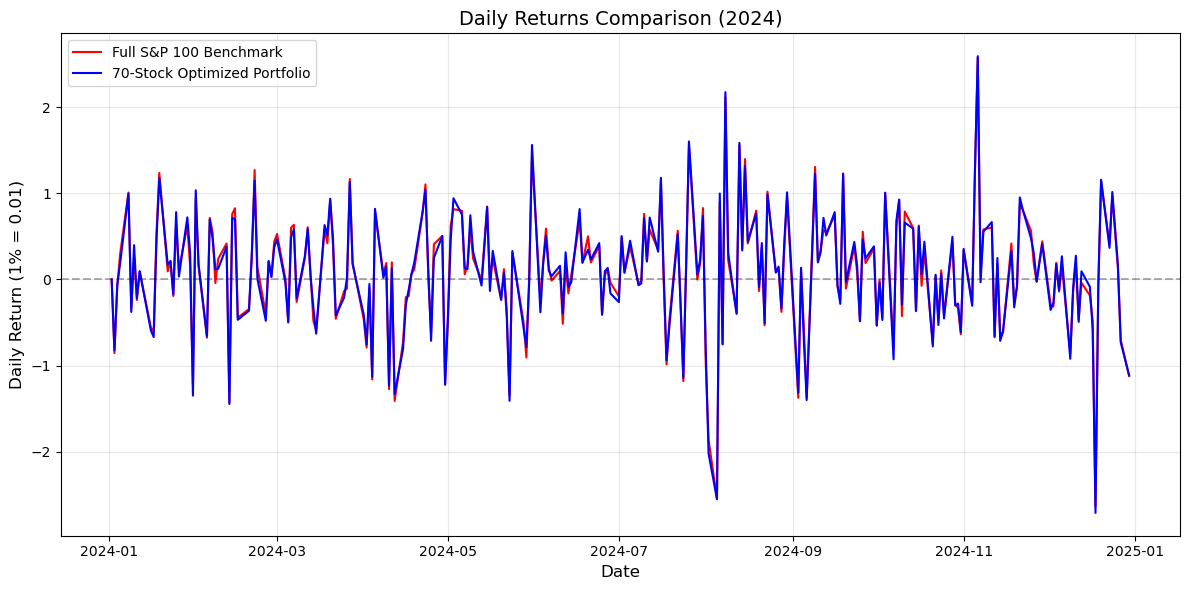

In [5]:
optimized_weights = pd.Series(weights.value, index=daily_returns.columns)
portfolio_returns = daily_returns @ optimized_weights

benchmark_weights = np.ones(len(daily_returns.columns)) / len(daily_returns.columns)
benchmark_returns = daily_returns @ benchmark_weights

#Performance df
performance = pd.DataFrame({
    'Benchmark': benchmark_returns,
    'Optimized_Portfolio': portfolio_returns
}, index=daily_returns.index)

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Benchmark', color='red', label='Full S&P 100 Benchmark') #Actual SP100 red
sns.lineplot(data=performance, x=performance.index, y='Optimized_Portfolio',color='blue', label='70-Stock Optimized Portfolio') #Our version blue
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Daily Returns Comparison (2024)", fontsize=14)
plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

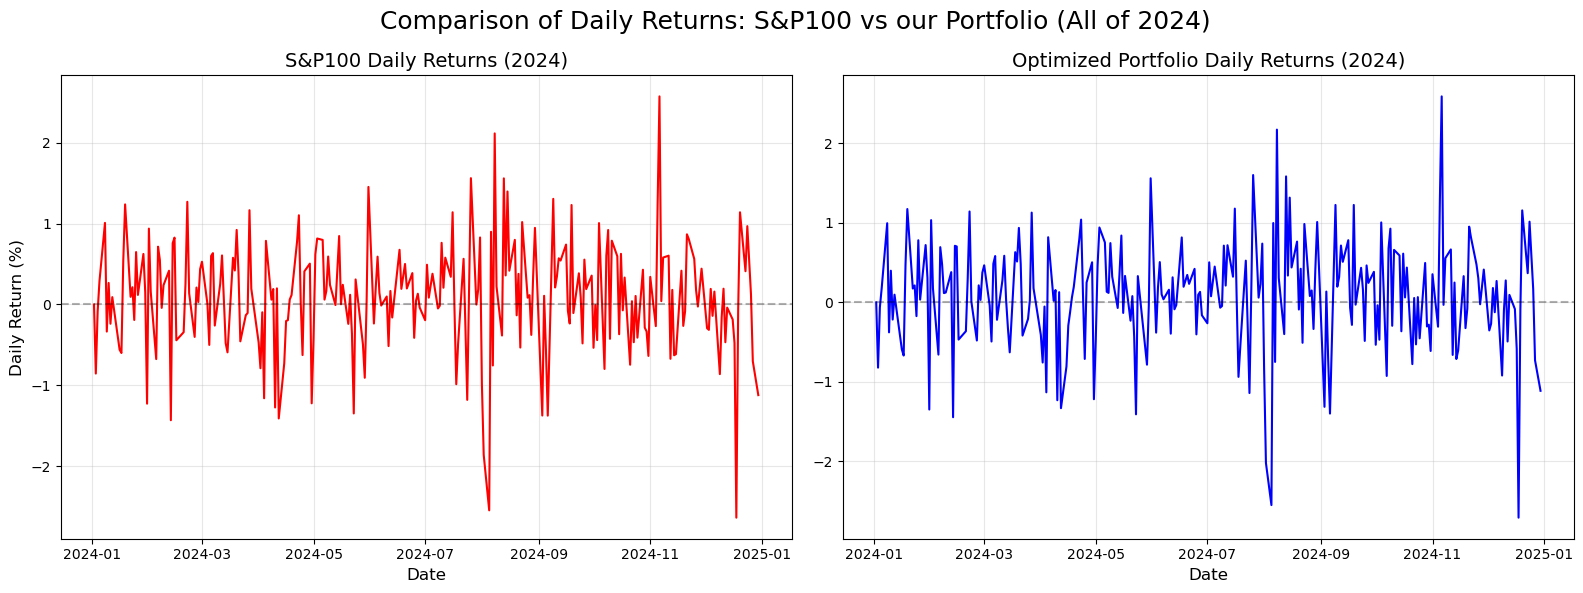

In [22]:
plt.figure(figsize=(16, 6))
plt.suptitle("Comparison of Daily Returns: S&P100 vs our Portfolio (All of 2024)",fontsize=18)

#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=performance, x=performance.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=performance, x=performance.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.ylim()
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Whats the difference?

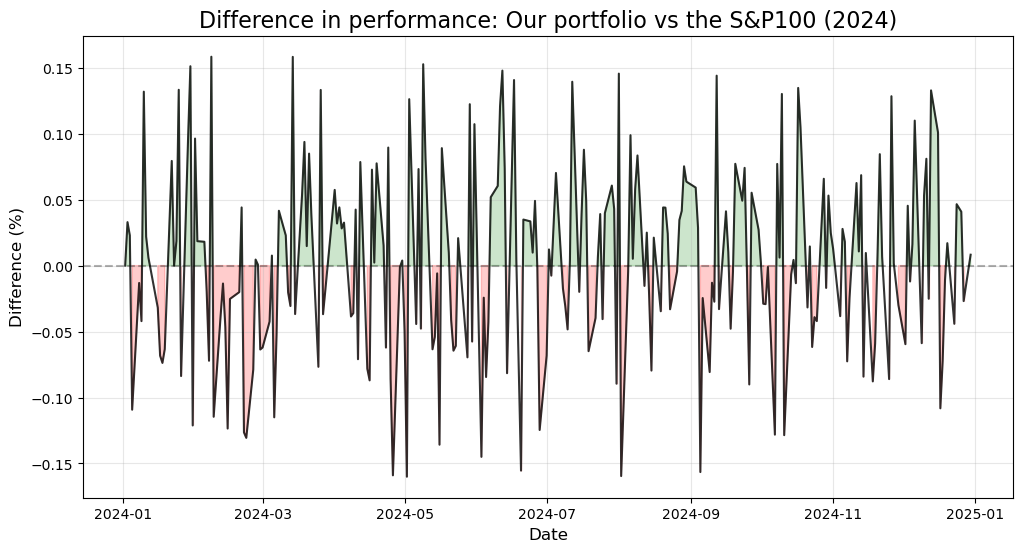

In [23]:
performance['Difference'] = performance['Optimized_Portfolio'] - performance['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (2024)", fontsize=16)
plt.ylabel("Difference (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

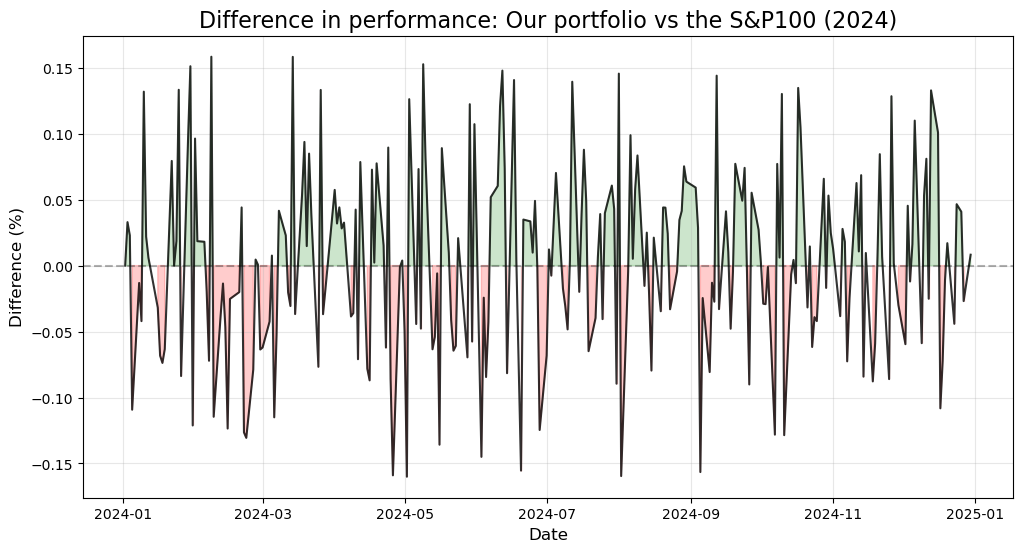

In [25]:
performance['Difference'] = performance['Optimized_Portfolio'] - performance['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (2024)", fontsize=16)
plt.ylabel("Difference (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

## Over 1st quarter of 2024

In [9]:
DRQ1 = performance[0:61]#Q1

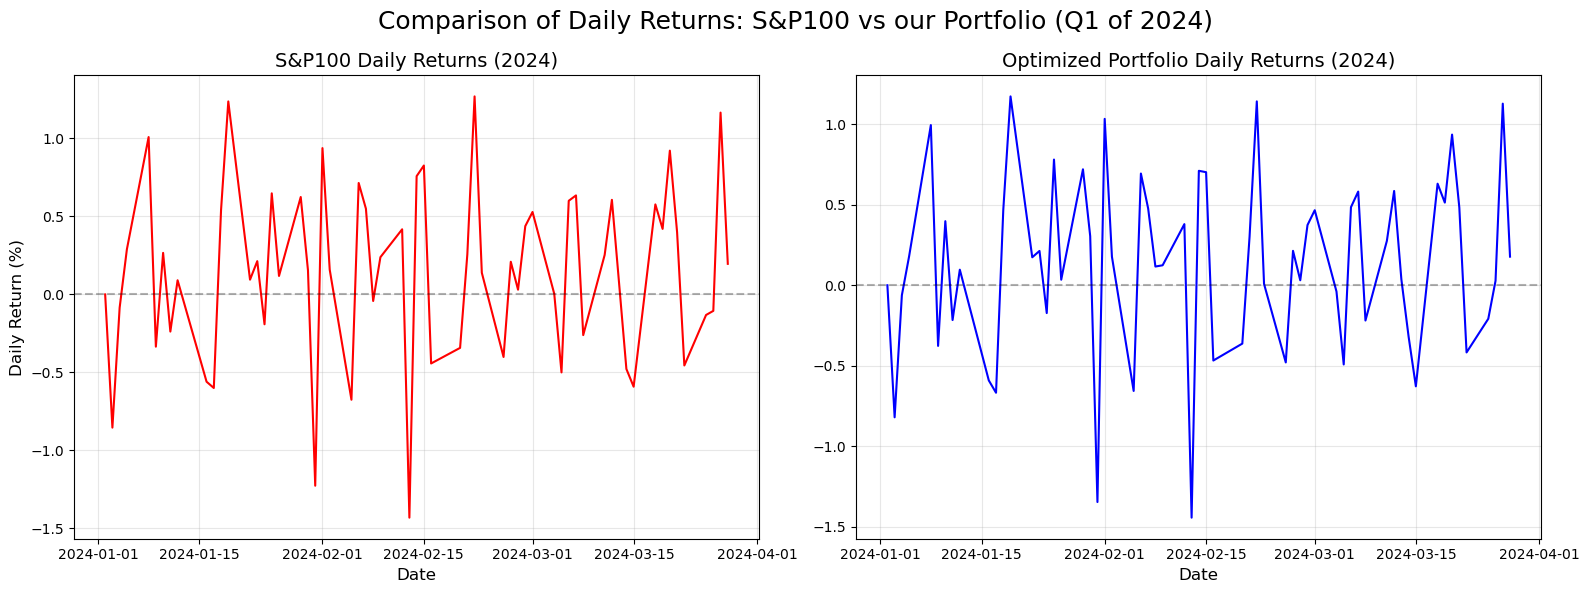

In [26]:
plt.figure(figsize=(16, 6))
plt.suptitle("Comparison of Daily Returns: S&P100 vs our Portfolio (Q1 of 2024)",fontsize=18)

#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=DRQ1, x=DRQ1.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=DRQ1, x=DRQ1.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.ylim()
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\Hugh\AppData\Local\Temp\ipykernel_952\3002662565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRQ1['Difference'] = DRQ1['Optimized_Portfolio'] - DRQ1['Benchmark']


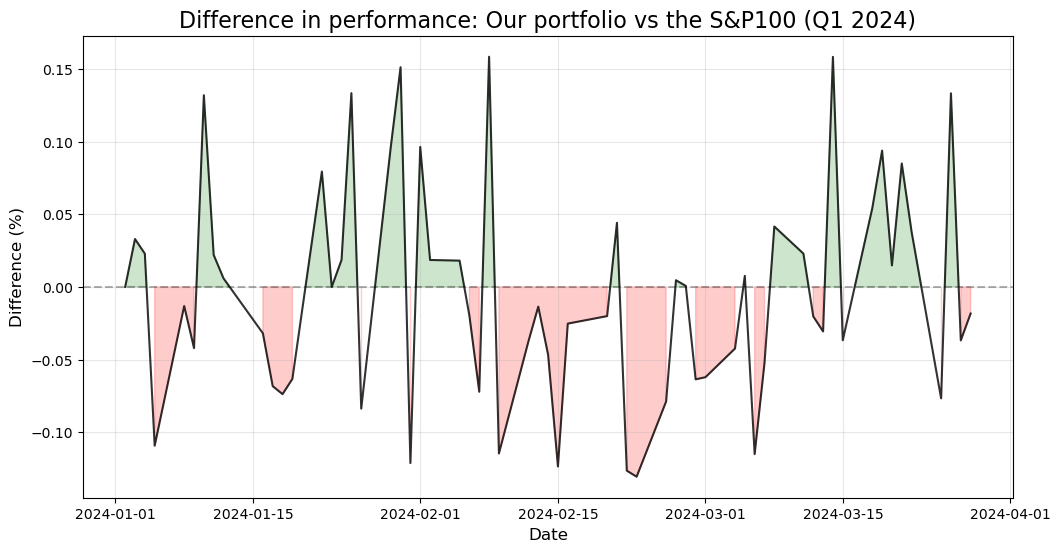

In [27]:
DRQ1['Difference'] = DRQ1['Optimized_Portfolio'] - DRQ1['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=DRQ1, x=DRQ1.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (Q1 2024)", fontsize=16)
plt.ylabel("Difference (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(DRQ1.index, DRQ1['Difference'], 0, 
                 where=(DRQ1['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(DRQ1.index, DRQ1['Difference'], 0, 
                 where=(DRQ1['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

## Over first 2 quarters of 2024

In [12]:
DRQ2 = performance[0:124] #q2

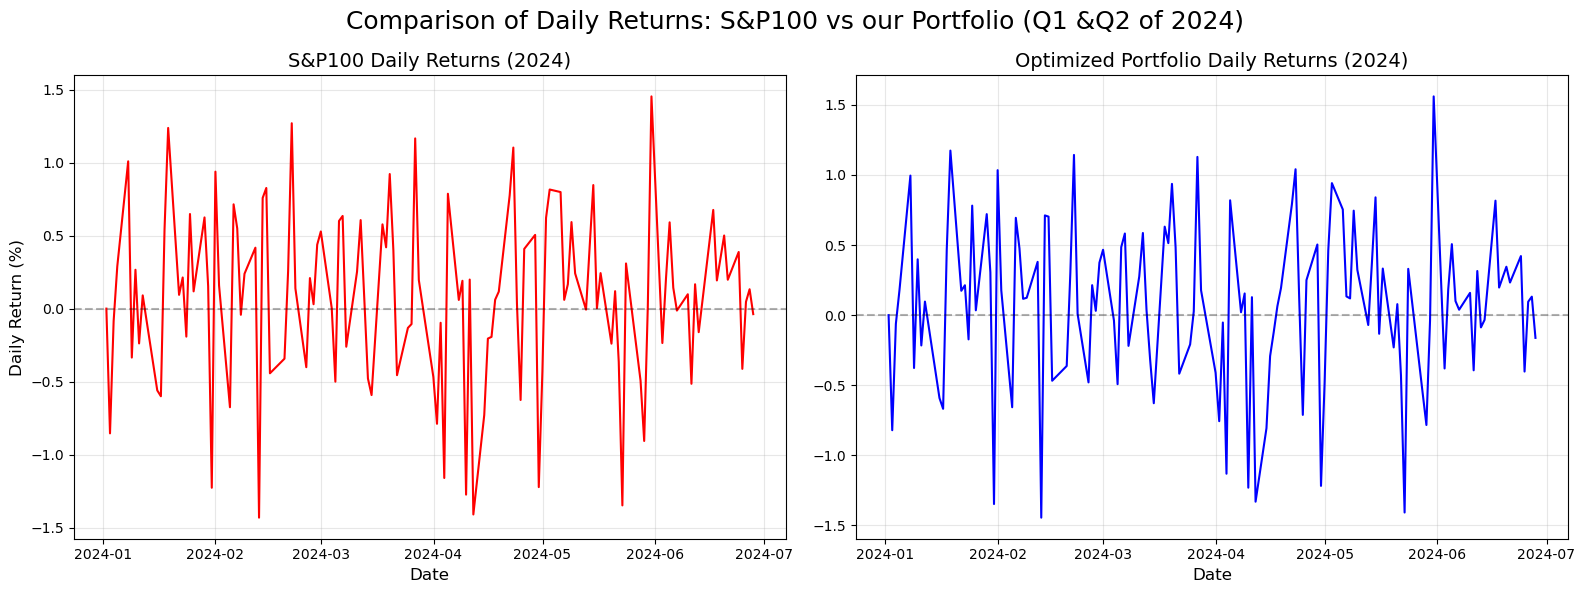

In [28]:
plt.figure(figsize=(16, 6))
plt.suptitle("Comparison of Daily Returns: S&P100 vs our Portfolio (Q1 &Q2 of 2024)",fontsize=18)
#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=DRQ2, x=DRQ2.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=DRQ2, x=DRQ2.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.ylim()
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\Hugh\AppData\Local\Temp\ipykernel_952\3425251777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRQ2['Difference'] = DRQ2['Optimized_Portfolio'] - DRQ2['Benchmark']


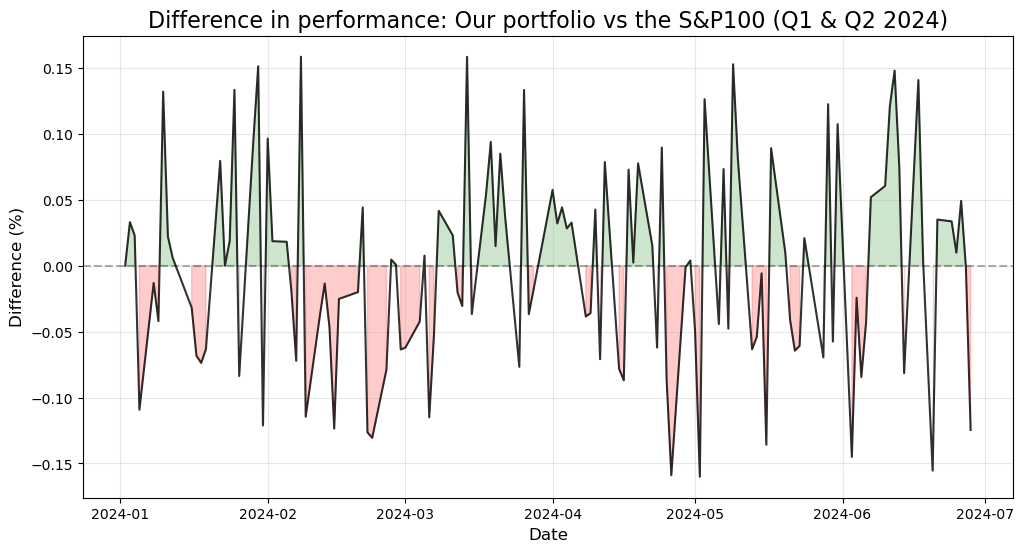

In [29]:
DRQ2['Difference'] = DRQ2['Optimized_Portfolio'] - DRQ2['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=DRQ2, x=DRQ2.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (Q1 & Q2 2024)", fontsize=16)
plt.ylabel("Difference (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(DRQ2.index, DRQ2['Difference'], 0, 
                 where=(DRQ2['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(DRQ2.index, DRQ2['Difference'], 0, 
                 where=(DRQ2['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

## Over first 3 quarters of 2024

In [15]:
DRQ3 = performance[0:188] #q3

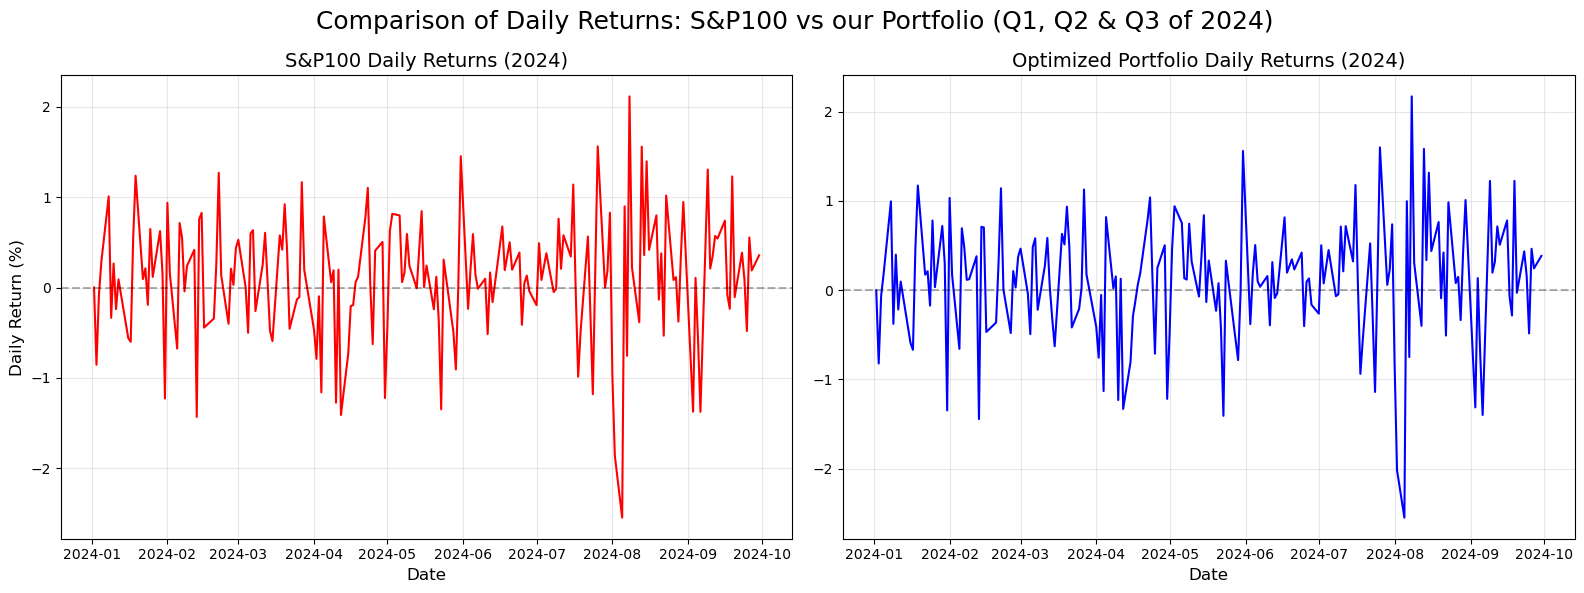

In [30]:
plt.figure(figsize=(16, 6))
plt.suptitle("Comparison of Daily Returns: S&P100 vs our Portfolio (Q1, Q2 & Q3 of 2024)",fontsize=18)

#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=DRQ3, x=DRQ3.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=DRQ3, x=DRQ3.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.ylim()
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\Hugh\AppData\Local\Temp\ipykernel_952\2546012932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DRQ3['Difference'] = DRQ3['Optimized_Portfolio'] - DRQ3['Benchmark']


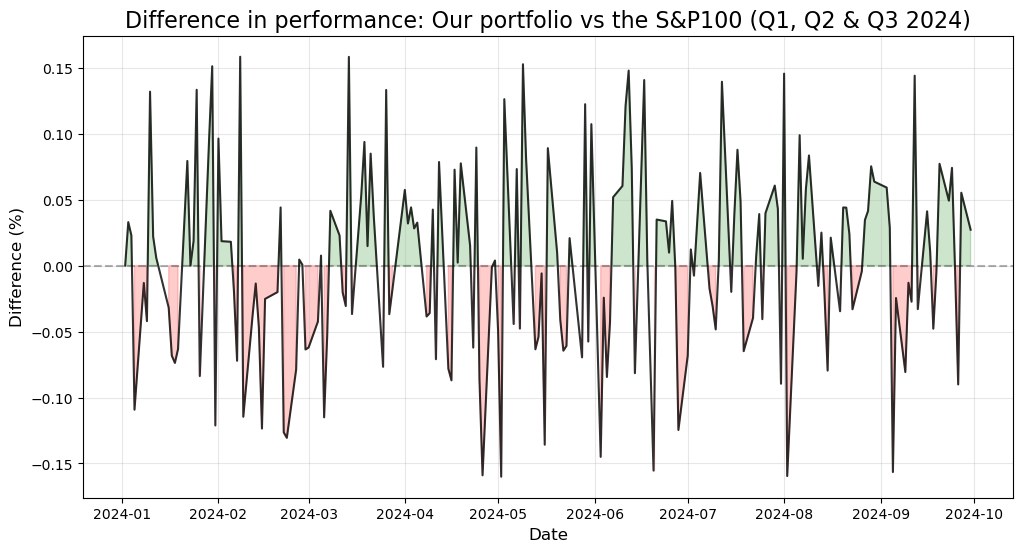

In [31]:
DRQ3['Difference'] = DRQ3['Optimized_Portfolio'] - DRQ3['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=DRQ3, x=DRQ3.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (Q1, Q2 & Q3 2024)", fontsize=16)
plt.ylabel("Difference (%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim()
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(DRQ3.index, DRQ3['Difference'], 0, 
                 where=(DRQ3['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(DRQ3.index, DRQ3['Difference'], 0, 
                 where=(DRQ3['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()